# Assignment 1 (Code)

The following section presents the code results for the assignment, followed by the report at the end.

**Name**: Gabriel Martinez

**Course**: WES 237A

**GitHub**: [https://github.com/Math140Instructor/wes237a/Assignment 1](https://github.com/Math140Instructor/wes237a/tree/main/Assignment%201)


1.	Use the gpio.ipynb from lab as a starting point. Add a C++ function to reset all the GPIO pins on the chosen PMOD.

In [2]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
btns = base.btns_gpio

In [3]:
%%microblaze base.PMODB

#include "gpio.h"

const unsigned int R = 3, G = 2, B = 1;
gpio parent = gpio_open_device(0);
gpio ledPins = gpio_configure(parent, B, R, 1);  // D1..D3

int write(unsigned int rgb){
    gpio_set_direction(ledPins, GPIO_OUT);
    gpio_write(ledPins, rgb);
    return rgb;
}

int reset(){ // set to read only which changes led to default green state
    gpio_set_direction(ledPins,GPIO_IN);
    return 0;
}

In [4]:
# OFF 0x000 since no bits are powered
write(0)

0

In [5]:
# Read only default color is green
reset()

0

In [6]:
# Blue since B is the first bit in RGB => 0b001 <=> 1 decimal 
write(1)

1

In [7]:
# Green since G is the second bit in RGB => 0b010 <=> 2 decimal
write(2)

2

In [8]:
# Red since R is the third bit in RGB => 0b100 <=> 4 decimal
write(4)

4

2.	Write a Python3 cell that emulates a PWM (for a chosen frequency and duty cycle) on one of the PMOD GPIO pins. For example, PMODB PIN3 needs to turn on for duty cycle percent of the square wave frequency and off for the rest of the square wave. It may not be possible to achieve exactly 0% or 100% so be sure to add necessary code for those corner cases.

In [9]:
%%microblaze base.PMODB

#include "gpio.h"
#include "pyprintf.h"
#include "yield.h"
#include "timer.h"

const unsigned int R = 3, G = 2, B = 1;
gpio parent = gpio_open_device(0);
gpio ledPins = gpio_configure(parent, B, R, 1);  // D1..D3

unsigned int global_freq = 1, global_duty= 50, global_rgb_val = 7,is_pwm_running = 0;

// DEBUG
int write(unsigned int rgb){
    gpio_set_direction(ledPins, GPIO_OUT);
    gpio_write(ledPins, rgb);
    return rgb;
}

// DEBUG
int init()
{
    pyprintf("init ok\r\n");
    return write(7);
}

int pwm_set(unsigned int freq_hz, unsigned int duty)
{
    global_freq = freq_hz==0 ? 1:freq_hz;
    global_duty = duty>100 ? 100:duty;
    return 0;
}

int pwm_set_rgb(unsigned int rgb_val)
{
    global_rgb_val = rgb_val>7? 7 : rgb_val;
    return 0;
}

int pwm_blink_global(){
    gpio_set_direction(ledPins, GPIO_OUT);

    unsigned int freq = global_freq;
    unsigned int duty = global_duty;
    unsigned int val  = global_rgb_val;

    unsigned int us = 1000000; // work in micro secs
    unsigned int T =  (us / freq);

    unsigned int on_us  = (T * duty) / 100;
    unsigned int off_us = T - on_us;

    gpio_write(ledPins, val);
    delay_us(on_us);
    gpio_write(ledPins, 0);
    delay_us(off_us);

    return 0;
}

int pwm_blink(unsigned int freqq, unsigned int dutyy, unsigned int rgb){
    
    gpio_set_direction(ledPins, GPIO_OUT);
    
    pwm_set_rgb(rgb);
    pwm_set(freqq,dutyy);
    
    unsigned int freq = global_freq;
    unsigned int duty = global_duty;
    unsigned int val  = global_rgb_val;

    unsigned int us = 1000000; // work in micro secs
    unsigned int T =  (us / freq);

    unsigned int on_us  = (T * duty) / 100;
    unsigned int off_us = T - on_us;

    gpio_write(ledPins, val);
    delay_us(on_us);
    gpio_write(ledPins, 0);
    delay_us(off_us);

    return 0;
}

int pwm_on_for_seconds(unsigned int seconds)
{
    gpio_set_direction(ledPins, GPIO_OUT);

    unsigned int elapsed_us = 0;
    unsigned int run_time_us = seconds * 1000000u;

    while (elapsed_us < run_time_us)
    {
        unsigned int freq = global_freq;
        unsigned int duty = global_duty;
        unsigned int val  = global_rgb_val;

        unsigned int T = 1000000u / freq; // us
        pwm_blink(freq,duty,val);

        elapsed_us += T;
        yield();
    }

    gpio_write(ledPins, 0);
    return 0;
}
// void methods run asynchronously
void pwm_on()
{
    gpio_set_direction(ledPins, GPIO_OUT);
    is_pwm_running=1;
    
    while (is_pwm_running)
    {
        pwm_blink(global_freq, global_duty, global_rgb_val);
        yield();
    }
}

int reset(){
    is_pwm_running=0;
    gpio_set_direction(ledPins,GPIO_IN);
    return 0;
}

int pwm_off()
{
    return reset();
    //gpio_close(ledPins);
}

In [10]:
init()

init ok


7

In [11]:
# Using asyncio for PMODB pins
import asyncio

cond = True
color = 7 # white
freq = 60  # Hz
duty = 100 # 100% duty cycle

# start PWM once on MicroBlaze
pwm_set_rgb(color)
pwm_set(freq, duty)
pwm_on()
print("flashing...")

async def get_btns(_loop):
    global cond, color, freq, duty
    print("button listening...")
    while cond:
        await asyncio.sleep(0.001)
        if btns.read() & 0b1000 : #button 3  exit
            freq=1
            color=0;
            cond = False
            pwm_off()
            await asyncio.sleep(0.5)
            _loop.stop()
        if btns.read() & 0b0100: #button 2 increase duty cycle
            duty = (duty+1)%101;
            pwm_set(freq,duty)
            print("duty cycle %d" % duty)
            await asyncio.sleep(0.1)
    print("button listener done.")

loop = asyncio.new_event_loop()
loop.create_task(get_btns(loop))
loop.run_forever()
loop.close()
pwm_off()
print("Done.")

flashing...
button listening...
duty cycle 0
duty cycle 1
duty cycle 2
duty cycle 3
duty cycle 4
duty cycle 5
duty cycle 6
duty cycle 7
duty cycle 8
duty cycle 9
duty cycle 10
duty cycle 11
duty cycle 12
duty cycle 13
duty cycle 14
duty cycle 15
duty cycle 16
duty cycle 17
duty cycle 18
duty cycle 19
duty cycle 20
duty cycle 21
duty cycle 22
duty cycle 23
duty cycle 24
duty cycle 25
duty cycle 26
duty cycle 27
duty cycle 28
duty cycle 29
duty cycle 30
duty cycle 31
duty cycle 32
duty cycle 33
duty cycle 34
duty cycle 35
duty cycle 36
duty cycle 37
duty cycle 38
duty cycle 39
duty cycle 40
duty cycle 41
duty cycle 42
duty cycle 43
duty cycle 44
duty cycle 45
duty cycle 46
duty cycle 47
duty cycle 48
duty cycle 49
duty cycle 50
duty cycle 51
duty cycle 52
duty cycle 53
duty cycle 54
duty cycle 55
duty cycle 56
duty cycle 57
duty cycle 58
duty cycle 59
duty cycle 60
duty cycle 61
duty cycle 62
duty cycle 63
duty cycle 64
duty cycle 65
duty cycle 66
duty cycle 67
duty cycle 68
duty cycle 6

In [12]:
# headless test to vary duty cycle & flash 
# Choose 60Hz for testing
# sweep duty cycle from 0 to 100
# test duration 5 iterations 

# duty cycle test. LED will slowly increase in brightness. 
hz=60
testIterations=0
numTest=1
while testIterations < numTest:
    for i in range(0,101):
        pwm_set(hz,i)
        pwm_blink(hz,i,7)
        print("duty: %d%%"%i)
    testIterations = testIterations+1
print("duty cycle test done.")

duty: 0%
duty: 1%
duty: 2%
duty: 3%
duty: 4%
duty: 5%
duty: 6%
duty: 7%
duty: 8%
duty: 9%
duty: 10%
duty: 11%
duty: 12%
duty: 13%
duty: 14%
duty: 15%
duty: 16%
duty: 17%
duty: 18%
duty: 19%
duty: 20%
duty: 21%
duty: 22%
duty: 23%
duty: 24%
duty: 25%
duty: 26%
duty: 27%
duty: 28%
duty: 29%
duty: 30%
duty: 31%
duty: 32%
duty: 33%
duty: 34%
duty: 35%
duty: 36%
duty: 37%
duty: 38%
duty: 39%
duty: 40%
duty: 41%
duty: 42%
duty: 43%
duty: 44%
duty: 45%
duty: 46%
duty: 47%
duty: 48%
duty: 49%
duty: 50%
duty: 51%
duty: 52%
duty: 53%
duty: 54%
duty: 55%
duty: 56%
duty: 57%
duty: 58%
duty: 59%
duty: 60%
duty: 61%
duty: 62%
duty: 63%
duty: 64%
duty: 65%
duty: 66%
duty: 67%
duty: 68%
duty: 69%
duty: 70%
duty: 71%
duty: 72%
duty: 73%
duty: 74%
duty: 75%
duty: 76%
duty: 77%
duty: 78%
duty: 79%
duty: 80%
duty: 81%
duty: 82%
duty: 83%
duty: 84%
duty: 85%
duty: 86%
duty: 87%
duty: 88%
duty: 89%
duty: 90%
duty: 91%
duty: 92%
duty: 93%
duty: 94%
duty: 95%
duty: 96%
duty: 97%
duty: 98%
duty: 99%
duty: 100%

In [13]:
# Hz blink test. LED will increase its blinking until no visible flashing with a fixed duty cycle at 50% since it gives equal time on and off. 
# I tested at 10% to see if I would notice the fainter light. No, I stopped noticing the blink around ~42Hz.
duty=50
testIterations=0
numTest=1
while testIterations < numTest:
    for i in range(1,61):
        pwm_set(i,duty)
        pwm_on_for_seconds(2)
        print("%dHz"%i)
    testIterations = testIterations+1
print("Hz test done.")

1Hz
2Hz
3Hz
4Hz
5Hz
6Hz
7Hz
8Hz
9Hz
10Hz
11Hz
12Hz
13Hz
14Hz
15Hz
16Hz
17Hz
18Hz
19Hz
20Hz
21Hz
22Hz
23Hz
24Hz
25Hz
26Hz
27Hz
28Hz
29Hz
30Hz
31Hz
32Hz
33Hz
34Hz
35Hz
36Hz
37Hz
38Hz
39Hz
40Hz
41Hz
42Hz
43Hz
44Hz
45Hz
46Hz
47Hz
48Hz
49Hz
50Hz
51Hz
52Hz
53Hz
54Hz
55Hz
56Hz
57Hz
58Hz
59Hz
60Hz
Hz test done.


4.	Achieve the visually perceived 100%, 75%, 50% and 25% of full LED brightness by adjusting the duty cycle.

In [14]:
# I'll choose 42Hz since it appears stable to me
# show 0%, 25%, 50%, 75% and 100% duty cycle
# test duration for 5 secs
hz=42
testDuration=5
dutyIndx=[0,25,50,75,100]
for i in range(len(dutyIndx)):
    print("duty cycle: %d%% %dHz"%(dutyIndx[i],hz))
    pwm_set(hz,dutyIndx[i])
    pwm_set_rgb(7)
    pwm_on_for_seconds(5)
print("duty cycle test for 0%, 25%, 50%, 75% and 100% done.")

duty cycle: 0% 42Hz
duty cycle: 25% 42Hz
duty cycle: 50% 42Hz
duty cycle: 75% 42Hz
duty cycle: 100% 42Hz
duty cycle test for 0%, 25%, 50%, 75% and 100% done.


5.	Varying the duty cycles and approximate the corresponding LED brightness (in the unit of %). To the end, plot and explain the approximate relationship of % brightness versus duty cycle. While working on this task, feel free to check out the Weber-Fechner law. For light perception, this law describes the observation that our eyes perceive light in a non-linear way.

I plotted duty cycle percentage against the accumulated on time in seconds, treating brightness as a running average of how long the LED is on. The goal was to relate total on time over repeated PWM periods to duty cycle percentage, under the assumption that perceived brightness is proportional to the fraction of time the LED is on. A second plot shows the ideal linear relationship between duty cycle percentage and on time ratio for comparison.

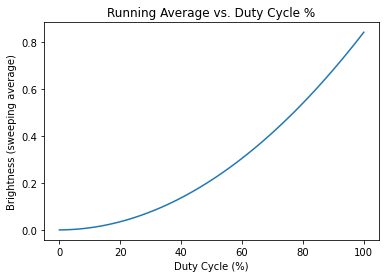

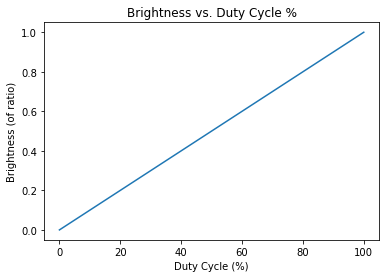

In [15]:
# plot duty cycle and brightness
import matplotlib.pyplot as plt
duty_vals = []
brightness_vals = []
hz=60
avg=0 # keep track of the running average

for i in range(0, 101):
    pwm_set(hz, i)
    pwm_blink(hz, i, 7)
    duty_vals.append(i)
    on=1./hz*i/100 # part of the energy for duty cycle 
    avg = avg+on
    brightness_vals.append(avg)

plt.plot(duty_vals, brightness_vals)
plt.title("Running Average vs. Duty Cycle %")
plt.xlabel("Duty Cycle (%)")
plt.ylabel("Brightness (sweeping average)")
plt.show()

plt.plot(duty_vals,[d/(100) for d in duty_vals]) # 1% of 60Hz
plt.xlabel("Duty Cycle (%)")
plt.ylabel("Brightness (of ratio)")
plt.title("Brightness vs. Duty Cycle %")
plt.show()


6.	After you have experimented with various PWM frequencies and duty cycles, add the following functionalities for a fixed duty cycle (i.e. 25%). You’ll want to use asyncio for this part.
- Start the code and blink the LED’s red channel in intervals of 1 second (i.e. 1 second on, 1 second off)
- When buttons 0, 1, or 2 are pushed, the LED will change color from Red, to Green, to Blue.
- When button 3 is pushed, the LED will stop blinking.
- Your video should demonstrate how each button change to each of the (4)

In [16]:
# Using asyncio for PMODA pins
import asyncio

cond = True
color = 4 # red
freq = 1  # 1 blink per sec (1Hz)
duty = 50 # 50% duty cycle

# start PWM once on MicroBlaze
pwm_set_rgb(color)
pwm_set(freq, duty)
pwm_on()

async def get_btns(_loop):
    global cond, color, freq, duty
    hzMax = 60
    while cond:
        await asyncio.sleep(0.005)
        if btns.read() & 0b1000 : #button 3
            freq=1
            color=0;
            cond = False
            pwm_off()
            await asyncio.sleep(0.5)
            _loop.stop()
        if btns.read() & 0b0100: #button 2
            color = 4
            freq = max(1, (freq+1) % hzMax) # not needed for assignment just nice to have
            pwm_set_rgb(color)
            pwm_set(freq, duty)
            print("red %d Hz %d%%" % (freq,duty))
            await asyncio.sleep(0.02)
        if btns.read() & 0b0010: # button 1
            color = 2
            freq = max(1, (freq+1) % hzMax) # not needed for assignment just nice to have
            pwm_set_rgb(color)
            pwm_set(freq, duty)
            print("green %dHz %d%%" % (freq,duty))
            await asyncio.sleep(0.02)
        if btns.read() & 0b0001: # button 0
            color = 1
            freq = max(1, (freq+1) % hzMax) # not needed for assignment just nice to have
            pwm_set_rgb(color)
            pwm_set(freq, duty)
            print("blue %dHz %d%%" % (freq,duty))
            await asyncio.sleep(0.02)
    print("button listener done.")

loop = asyncio.new_event_loop()
loop.create_task(get_btns(loop))
loop.run_forever()
loop.close()
pwm_off()
print("Done.")

blue 2Hz 50%
green 3Hz 50%
red 4 Hz 50%
green 5Hz 50%
blue 6Hz 50%
blue 7Hz 50%
green 8Hz 50%
red 9 Hz 50%
red 10 Hz 50%
green 11Hz 50%
blue 12Hz 50%
blue 13Hz 50%
button listener done.
Done.


In [17]:
from IPython.display import Video, display
display(Video("assignment1.mp4", embed=True))

# Assignment 1 (Report)

**Name**: Gabriel Martinez

**Course**: WES 237A

**GitHub**: [https://github.com/Math140Instructor/wes237a/Assignment 1](https://github.com/Math140Instructor/wes237a/tree/main/Assignment%201)


## 1. Objective

The objective of this assignment was to investigate, emulate and develop a functional Pulse Width Modulation (PWM) scheme to light an LED peripheral using a PYNQ Z2 board.


## 2. Design Methodology

A top down design methodology was used to structure the implementation. The overall problem was decomposed into smaller, testable components:

1. I generated a stable PWM signal and started with a single blink at 1Hz at a 50% duty cycle and built off of that. Since, I knew I was expecting a blink per second so it was easy to debug manually. 
2. Then after I was happy with that I moved on to varying the duty cycle from 0-100%. 
3. From there I parameterized the duty cycle and blink rate.
4. I approximated perceived brightness by coming up with my own metric since there is no way to "measure" brightness (at least no tools on hand). My "metric" kept a fixed frequency and swept  through the different duty cycle at each percent with a step size of 1% keeping track of the summation of total light on essentially.
5. A lot of modular tesing to visualize and interpret the results. Mainly, all done manually in incremental steps. Then automated using a for loop. This created a headless testing environment for which I didn't need to interact with the board until I was happy with my methods. I applied the same approach of testing strategy of button presses, then added asyncio and then integrated the methods into the PMOD A module to produce the final result of changing the color of an LED on a button press with a bonus of also increasing the frequecny after each press and logging the output to the console in python to verify correctness and validation.  

TL;DR. Each component was verified independently before integrating into the final workflow.


## 3. Workflow and Implementation

### 3.1 PWM Signal Generation

The PWM signal was designed to run continuously without blocking the system. Initial attempts using Python timing revealed limitations in timing precision at higher frequencies. My board would just crash and the led failed to stay on. To address this, I moved the PWM logic from python to MicroBlaze, and kept Python to only to update the frequency, duty cycle, and color parameters.

### 3.2 Duty Cycle Control

The duty cycle was defined as a percentage between 0 and 100. For a fixed PWM frequency, the on time for each cycle was computed as:


$ t_{on} =  \frac{1}{f} \cdot \frac{duty}{100} \cdot 1x10^6$
and $ t_{off} =  \frac{1}{f} - t_{on}$.

I wanted to work in units of microseconds, since nanoseconds is at the assembly level and I was working in C so realistically would be the "fastest" level of reliable measurements.

### 3.3 Brightness Approximation

I created my own metric. Perceived brightness was approximated as proportional to the accumulated "on time" of the LED. For each duty cycle step, the on time contribution was accumulated and treated as a relative brightness metric. While this approach does not model human vision exactly it was used a consistent basis for comparison across duty cycle values. I did note I was able to see more subtle changes at lower duty cycles than higher duty cycles, e.g., 10% vs 90%.

## 4. Difficulties and Troubleshooting

Several challenges were encountered during development. Python based PWM timing introduced jitter and limited maximum achievable frequency, which was resolved by delegating timing control to the MicroBlaze programming in C. Some of my classmates mentioned that functions in microblaze run asynchronously if used as a `void` function. That may have been my issue, but I had to do more digging around and found the `timer.h` and `yield.h` libraries that fixed my timing issues. Additionally, I had git management issues from accidentally tracking generated files such as FPGA bitstreams and notebook checkpoint directories. These were resolved by correcting the `.gitignore` configuration and removing previously tracked artifacts. Wasn't project related directly but still took some time. I want to create a seemless workflow where I have git setup on on the pynq board so when I'm done with my work I can just push results straight to my GitHub account.

## 5. Results and Analysis

I successfully controlled the LED using the GPIO pins on the PMODB interface. I created parameter driven test functions that emulate PWM in a headless manner, in addition to using GPIO buttons, which enabled faster testing and proved very helpful. The results demonstrate that pulse width modulation can be used to emulate a DAC, allowing the LED brightness, or perceived power, to be varied without changing any physical voltage levels.


## 7. Conclusion

Through this assignment, I learned how to use the PYNQ development environment to integrate Python, Jupyter notebooks, and MicroBlaze firmware for hardware control. I gained hands on experience implementing PWM using PMOD GPIO pins and developed an understanding of how the duty cycle and frequency influence on a LED behavior and perceived brightness. Overall, this assignment helped build a clearer understanding on pulse width modulation and how it can be used to emulate a digital to analog converter through time averaged LED control.

# Assignment 1

This directory contains the Jupyter notebooks and their corresponding rendered PDF outputs.

Each notebook (`.ipynb`) contains the source code and explanations, while the PDF provides a static, graded friendly version of the executed results.

---

## Deliverables

- **Code:** [assignment1.ipynb](./p1.ipynb)  
- **Output:** [assignment1.pdf](./p1.pdf)

## Demo Video

<video controls preload="metadata" width="800">
  <source src="./assignment1.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

---

### Notes
- PDFs are generated directly from their associated notebooks.
- Filenames with spaces are URL encoded (`%20`) for proper GitHub linking.
- Click any PDF to view it using GitHub’s built-in PDF viewer.
